In [84]:
%matplotlib inline
from datascience import *
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Markdown
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 18})

This project attempts to answer a simple question: approximately how many cars pass on my street? To do this, three steps were implemented: the building of a circuit for the senor to capture data. The code writes up to save the real-time data and to operate the sensor. Finally, using Statistical Analysis and table manipulation to filter the sampled data.

# Sampling Local Data

This data was collected by using the HC-SR04 Ultrasound Sensor and if applicable, the details of the circuit design is available [here](https://thepihut.com/blogs/raspberry-pi-tutorials/hc-sr04-ultrasonic-range-sensor-on-the-raspberry-pi).

The sensor uses the equation 
$$Distance = Velocity * Time \quad [\dfrac{m}{s}].$$

Since the sonar sends a pulse at 40KHz, and the Ultrasound Sensor captures the time that the wave is received, we can find the distance of an object relative to the sensor. Furthermore, the velocity of the sound wave is approximated by the speed of sound positioned at sea level of $34300 \dfrac{cm}{s}$. Thus, the equation is rewritten as 

$$ Distance  = \dfrac{33003}{2} [\dfrac{cm}{s}] * \Delta Time [s].$$

# Exploring the Sonar Data

The following functions are used to manipulate the data provided by the local sample.

In [85]:
# need to generalize the table filtering process to reduce the amount of code generated
def split_columns(tbl):
    """This function takes in a table and extracts all values and returns a nested list containing values by column"""
    tbl_values, labels = [], tbl.labels
    for label in labels:
        tbl_values.append(tbl.column(label))
    return tbl_values

def filter_numerical_entries(unfilter_tbl, labels):
    # convert numberical data from string to floats
    table = unfilter_tbl    
    for label in labels:
        temp = unfilter_tbl.apply(float, label)
        table = unfilter_tbl.with_column(label, temp) 
    return table

def update_columns(table, column_lst, labels):
    column_num = 0
    for label in labels:
        table = table.with_column(label, column_lst[column_num])
        column_num += 1
    return table

def plot_values(vector_a, vector_b, color='blue'):
    return plt.plot(vector_a, vector_b, color)
def scatter_values(vector_a, vector_b, color='blue'):
    return plt.scatter(vector_a, vector_b, color)

# selectors
def get_date(lst):
    return lst[0]
def get_epoch_time(lst):
    return lst[1]
def get_distance(lst):
    return lst[2]
def get_delta_time(lst):
    return lst[3]

When observing the sample data, the CSV file had appended an entry in the wrong column. So, the code below fixes this issue by removing the string from the defective entry.

In [86]:
sonar_data = 'sonar_data(second sample).csv'
sonar_table = Table.read_table(sonar_data).take(np.arange(0, 6015 - 1)).select(np.arange(4)).with_column('row num', np.arange(0, 6015 - 1))
# Fix the bad entry in the table
bad_row_num = int(sonar_table.where('Deltatime(S)', are.containing('Wed')).column('row num'))
print(bad_row_num)
column = sonar_table.column('Deltatime(S)')
column[bad_row_num] = 0.070223808
sonar_table = sonar_table.with_column('Deltatime(S)', column).drop('row num')

1115


Before manipulating the data, the entries provided by the sampling machine are an instance of the String class. Thus, numerical values must be converted.

In [87]:
sonar_labels = list(sonar_table.labels)[1:]
sonar_table = filter_numerical_entries(sonar_table, sonar_labels)
sonar_table.show(5)

Date,Time From Epoch(S),Distance(CM),Deltatime(S)
Wed Jan 6 11:45:33 2021,1.60996e+09,164.606,0.00959802
Wed Jan 6 11:45:34 2021,1.60996e+09,688.068,0.0401206
Wed Jan 6 11:45:35 2021,1.60996e+09,497.866,0.0290301
Wed Jan 6 11:45:36 2021,1.60996e+09,382.58,0.0223079
Wed Jan 6 11:45:37 2021,1.60996e+09,732.903,0.0427349


To see any relationships between the data sampled, every combination from the table are plotted in a scatterplot.

In [88]:
# Assign each column as an array
sonar_values = split_columns(sonar_table)
epoch_time = get_epoch_time(sonar_values)
distance_cm = get_distance(sonar_values)
deltatime = get_delta_time(sonar_values)

When plotting the recorded distance versus time, we see a near-perfect line. The relationship displayed can be interpreted as more time had passed in an interval, the distance recorded was greater.

While there are other measurements to be made from this information, this observation is not important for our problem. However, this relationship must be familiar, since the recorded results measured Velocity!

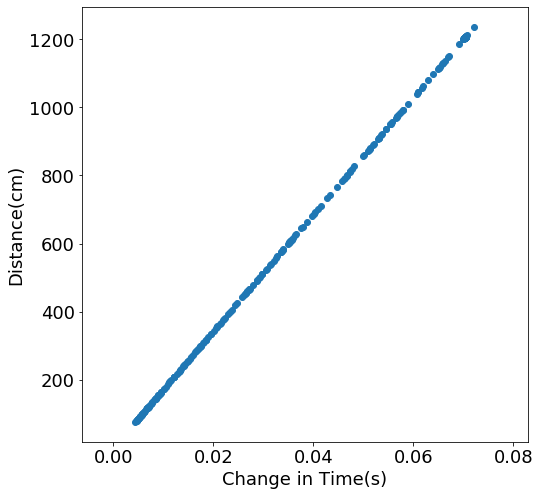

In [89]:
plt.scatter(deltatime, distance_cm);
plt.xlabel('Change in Time(s)')
plt.ylabel('Distance(cm)');

As observed from the distance versus time from the epoch, there is a practically constant line around 1200 centimeters. This is consistent with the maximum distance the sensor captured a reading when an object was not present. The rest of the points are reading by the sensor when an object did pass. 

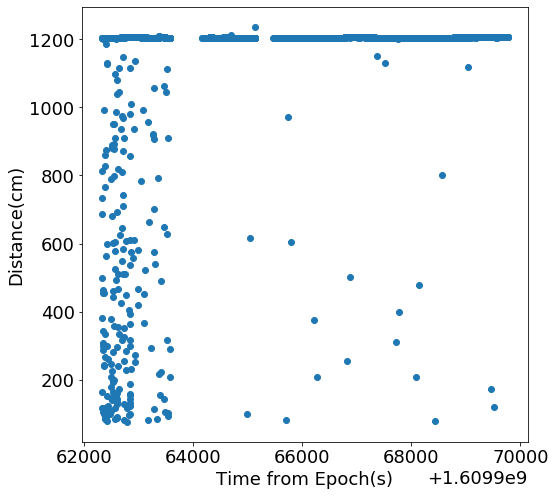

In [90]:
plt.scatter(epoch_time, distance_cm);
plt.xlabel('Time from Epoch(s)')
plt.ylabel('Distance(cm)');

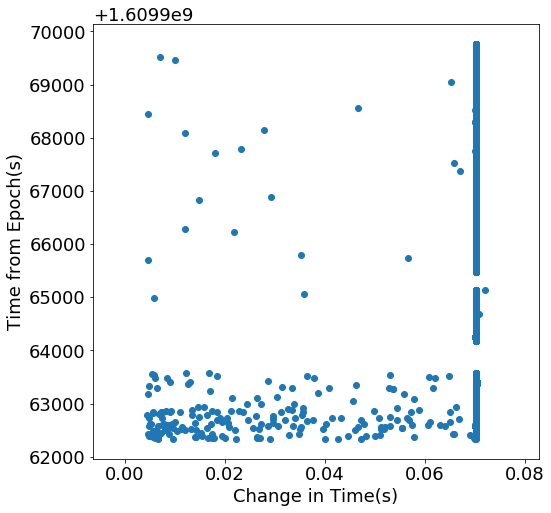

In [91]:
plt.scatter(deltatime, epoch_time);
plt.xlabel('Change in Time(s)')
plt.ylabel('Time from Epoch(s)');

Since there was a constant reading of approximately 1200cm with each passing second, we want to know when this was not the case. Therefore, we can omit the equilibrium readings.

In [92]:
measurement_error = 0.05
filtered_sonar_table = sonar_table.where("Distance(CM)", are.between(1200 * measurement_error, 
                                                        (1200 - 1200 * measurement_error)))
filtered_sonar_table.show(5)
filter_table_vals = split_columns(filtered_sonar_table)

filter_epoch_time = get_epoch_time(filter_table_vals)
filter_distance_cm = get_distance(filter_table_vals)
filter_deltatime = get_delta_time(filter_table_vals)

Date,Time From Epoch(S),Distance(CM),Deltatime(S)
Wed Jan 6 11:45:33 2021,1.60996e+09,164.606,0.00959802
Wed Jan 6 11:45:34 2021,1.60996e+09,688.068,0.0401206
Wed Jan 6 11:45:35 2021,1.60996e+09,497.866,0.0290301
Wed Jan 6 11:45:36 2021,1.60996e+09,382.58,0.0223079
Wed Jan 6 11:45:37 2021,1.60996e+09,732.903,0.0427349


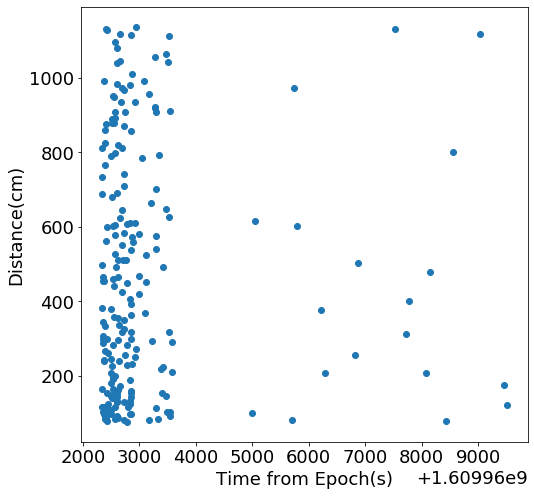

In [93]:
plt.scatter(filter_epoch_time, filter_distance_cm);
plt.xlabel('Time from Epoch(s)')
plt.ylabel('Distance(cm)');

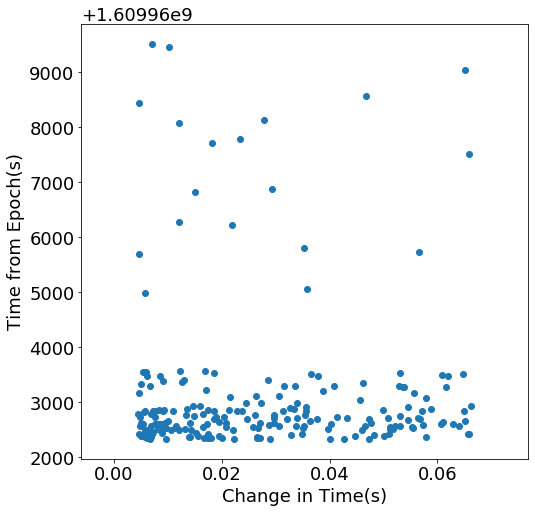

In [94]:
plt.scatter(filter_deltatime, filter_epoch_time);
plt.xlabel('Change in Time(s)')
plt.ylabel('Time from Epoch(s)');

During the data collection process, we observed that when a car passed, the sensor captured a car in approximately two seconds. So, we can filter the data further knowing this information.

In [95]:
# filtering the sonar table by the distances of the car traveled in two seconds 
# and reconstructing a new table 
filter_labels = list(filtered_sonar_table.labels[1:])
new_dates = [filtered_sonar_table.column('Date').item(date) 
             for date in np.arange(filtered_sonar_table.num_rows) if date % 2 == 0]

differences_tbl = Table().with_column('Date', new_dates) # new_sonar_table
diff_tbl_length = np.arange(0, filtered_sonar_table.num_rows - 1, 2)


diff_values = [[], [], []]
for elem in diff_tbl_length:
    diff_epoch = filter_epoch_time.item(elem + 1) - filter_epoch_time.item(elem)
    diff_distance = filter_distance_cm.item(elem + 1) - filter_distance_cm.item(elem)
    diff_delta_time = filter_deltatime.item(elem + 1) - filter_deltatime.item(elem)
    
    diff_values[0].append(diff_epoch)
    diff_values[1].append(diff_distance)
    diff_values[2].append(diff_delta_time)
    
differences_tbl = update_columns(differences_tbl, diff_values, filter_labels).relabel(
                    'Time From Epoch(S)', '(Epoch) Deltatime(S)')
differences_tbl.show(5)

Date,(Epoch) Deltatime(S),Distance(CM),Deltatime(S)
Wed Jan 6 11:45:33 2021,1,523.462,0.0305226
Wed Jan 6 11:45:35 2021,2,-115.286,-0.00672221
Wed Jan 6 11:45:37 2021,1,-617.237,-0.0359905
Wed Jan 6 11:45:39 2021,9,-357.859,-0.0208664
Wed Jan 6 11:45:49 2021,5,-176.717,-0.0103042


In [96]:
# filter the disances by approx 2 seconds
# will relax bounds: [79.5,  120.5].
temp_neg = differences_tbl.where('Distance(CM)', are.between(79.5, 120.5))
temp_pos = differences_tbl.where('Distance(CM)', are.between(-120.5, -79.5))
car_directions_tbl = temp_neg.append(temp_pos)
car_directions_tbl = car_directions_tbl.sort('Date')
car_directions_tbl.show()

Date,(Epoch) Deltatime(S),Distance(CM),Deltatime(S)
Wed Jan 6 11:45:35 2021,2,-115.286,-0.00672221
Wed Jan 6 11:48:10 2021,1,81.188,0.00473404
Wed Jan 6 11:48:24 2021,1,99.544,0.0058043
Wed Jan 6 11:49:01 2021,1,85.899,0.0050087
Wed Jan 6 11:49:21 2021,1,-93.844,-0.00547194
Wed Jan 6 11:50:31 2021,1,-114.186,-0.00665808
Wed Jan 6 11:51:34 2021,2,-94.976,-0.00553799
Wed Jan 6 11:52:02 2021,1,96.26,0.00561285
Wed Jan 6 12:05:50 2021,27,116.958,0.00681973


Since the sensor was facing the street, we can find the direction a vehicle passed the sensor. Two assumptions were made: 
1. When an object passed the sensor from the initial second, the following second that passed, the reading's result is relatively the same as the previous second.


2. From the readings that an object passed the sensor at the initial second, bigger distance values suggest that cars passed the sensor from the opposition lane and lower distance values suggest that cars passed the sensor from the right-most lane. 

With those assumptions in place, we can filter the table even further using these assumptions as conditions.

In [97]:
conditional_table = filtered_sonar_table.join('Date', car_directions_tbl, 'Date').select([0, 1, 2, 3, 4])
conditional_table.show()

Date,Time From Epoch(S),Distance(CM),Deltatime(S),(Epoch) Deltatime(S)
Wed Jan 6 11:45:35 2021,1.60996e+09,497.866,0.0290301,2
Wed Jan 6 11:48:10 2021,1.60996e+09,98.706,0.00575542,1
Wed Jan 6 11:48:24 2021,1.60996e+09,108.617,0.00633335,1
Wed Jan 6 11:49:01 2021,1.60996e+09,195.645,0.0114079,1
Wed Jan 6 11:49:21 2021,1.60996e+09,893.477,0.0520978,1
Wed Jan 6 11:50:31 2021,1.60996e+09,355.25,0.0207143,1
Wed Jan 6 11:51:34 2021,1.60996e+09,645.102,0.0376153,2
Wed Jan 6 11:52:02 2021,1.60996e+09,872.072,0.0508497,1
Wed Jan 6 12:05:50 2021,1.60996e+09,92.249,0.00537896,27


In [98]:
# Assign each column as an array
conditional_table_vals = split_columns(conditional_table)
cond_date = get_date(conditional_table_vals)
cond_epoch = get_epoch_time(conditional_table_vals)
cond_distance = get_distance(conditional_table_vals)
cond_delta_time = get_delta_time(conditional_table_vals)
cond_dt = conditional_table.column('(Epoch) Deltatime(S)')

Since the table is filtered by the two constraints imposed on the system, we will choose to use the average distance of the filtered cars to act as the decision boundary to determine if a vehicle is in the opposition lane or the right lane closest to the sensor. 

Mean Distance 417.6649 Cm


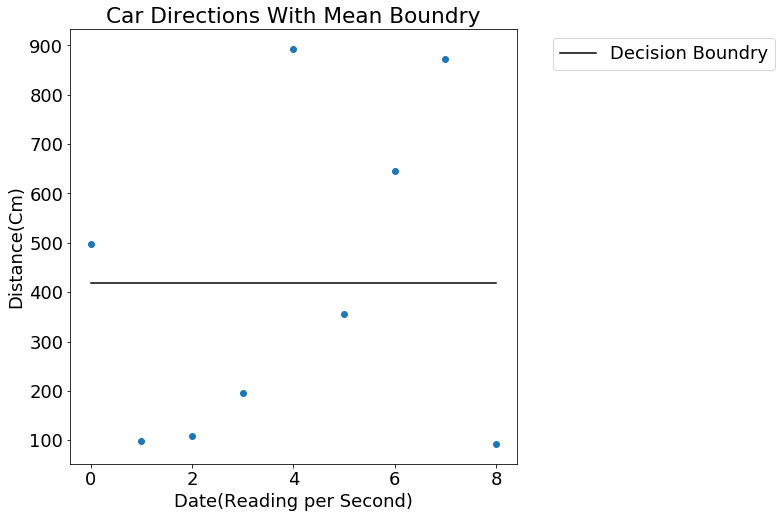

In [99]:
standardize_date = np.arange(len(cond_date)) 
cond_mean_distance = np.mean(cond_distance)
sample_mean_dist_arr = np.zeros(len(cond_date)) + cond_mean_distance

plt.scatter(standardize_date, cond_distance)
plt.plot(standardize_date, sample_mean_dist_arr, color = 'black', label='Decision Boundry');
plt.xlabel("Date(Reading per Second)")
plt.ylabel("Distance(Cm)")
plt.title("Car Directions With Mean Boundry")
plt.legend(bbox_to_anchor = (1.6, 1), loc='upper right');
print("Mean Distance", np.round(cond_mean_distance, 4), 'Cm')

To improve the accuracy of the decision boundary, a simulation will be used for the law of large numbers to become applicable. Thus, the decision boundary value for distance value will approach the average distance value. In the code below, $50,000$ simulations were conducted to determine the value of the decision boundary.

In [100]:
conditional_table.show()
results = make_array()
simulations = np.arange(50000)
for simulation in simulations:
    bootstrap = conditional_table.sample()
    sim_distance_mean = np.mean(bootstrap.column('Distance(CM)'))
    results = np.append(results, sim_distance_mean)

Date,Time From Epoch(S),Distance(CM),Deltatime(S),(Epoch) Deltatime(S)
Wed Jan 6 11:45:35 2021,1.60996e+09,497.866,0.0290301,2
Wed Jan 6 11:48:10 2021,1.60996e+09,98.706,0.00575542,1
Wed Jan 6 11:48:24 2021,1.60996e+09,108.617,0.00633335,1
Wed Jan 6 11:49:01 2021,1.60996e+09,195.645,0.0114079,1
Wed Jan 6 11:49:21 2021,1.60996e+09,893.477,0.0520978,1
Wed Jan 6 11:50:31 2021,1.60996e+09,355.25,0.0207143,1
Wed Jan 6 11:51:34 2021,1.60996e+09,645.102,0.0376153,2
Wed Jan 6 11:52:02 2021,1.60996e+09,872.072,0.0508497,1
Wed Jan 6 12:05:50 2021,1.60996e+09,92.249,0.00537896,27


Empirical Average Distance: 417.8953 CM


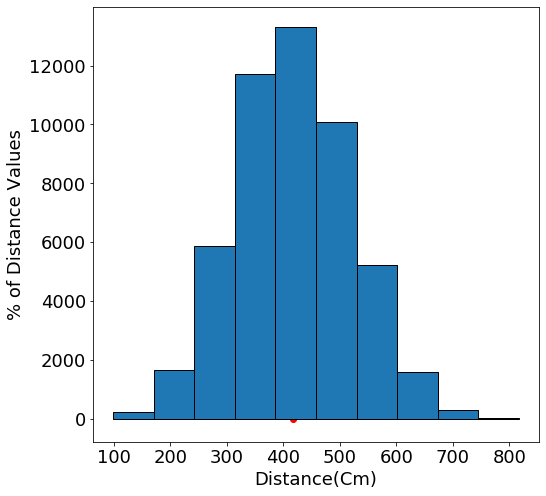

In [101]:
empirical_mean_distance = np.mean(results)
plt.hist(results);
plt.scatter(empirical_mean_distance, -10, color='red')
plt.xlabel("Distance(Cm)")
plt.ylabel("% of Distance Values")
print("Empirical Average Distance:", np.round(empirical_mean_distance, 4), "CM")

Using the empirical result of the average distance value, the data can be classified by direction.

In [102]:
def filter_car_direction(entry, measurement): 
    if entry < measurement:
        return 'Right Lane'
    return 'Opposite Lane'

def get_car_direction(tbl):
    return tbl.column("Car Direction")

def color_car_direction(tbl_entry):
    if tbl_entry == 'Right Lane':
        return 'orange'
    elif tbl_entry == 'Opposite Lane':
        return 'blue'
    
car_direction = [filter_car_direction(elem, empirical_mean_distance) for elem in cond_distance]
cond_direction_tbl = conditional_table.with_column("Car Direction", car_direction)
cond_direction_tbl.show()

Date,Time From Epoch(S),Distance(CM),Deltatime(S),(Epoch) Deltatime(S),Car Direction
Wed Jan 6 11:45:35 2021,1.60996e+09,497.866,0.0290301,2,Opposite Lane
Wed Jan 6 11:48:10 2021,1.60996e+09,98.706,0.00575542,1,Right Lane
Wed Jan 6 11:48:24 2021,1.60996e+09,108.617,0.00633335,1,Right Lane
Wed Jan 6 11:49:01 2021,1.60996e+09,195.645,0.0114079,1,Right Lane
Wed Jan 6 11:49:21 2021,1.60996e+09,893.477,0.0520978,1,Opposite Lane
Wed Jan 6 11:50:31 2021,1.60996e+09,355.25,0.0207143,1,Right Lane
Wed Jan 6 11:51:34 2021,1.60996e+09,645.102,0.0376153,2,Opposite Lane
Wed Jan 6 11:52:02 2021,1.60996e+09,872.072,0.0508497,1,Opposite Lane
Wed Jan 6 12:05:50 2021,1.60996e+09,92.249,0.00537896,27,Right Lane


In [103]:
cond_time_tracker_tbl = cond_direction_tbl.with_column("Standardize Time", np.arange(cond_direction_tbl.num_rows))
opposite_car = cond_time_tracker_tbl.where("Car Direction", are.containing("Opposite Lane")) 
right_car = cond_time_tracker_tbl.where("Car Direction", are.containing("Right Lane"))
empirical_dist_mean_arr = np.zeros(len(cond_date)) + empirical_mean_distance

Error Distance 1.0005516138722594


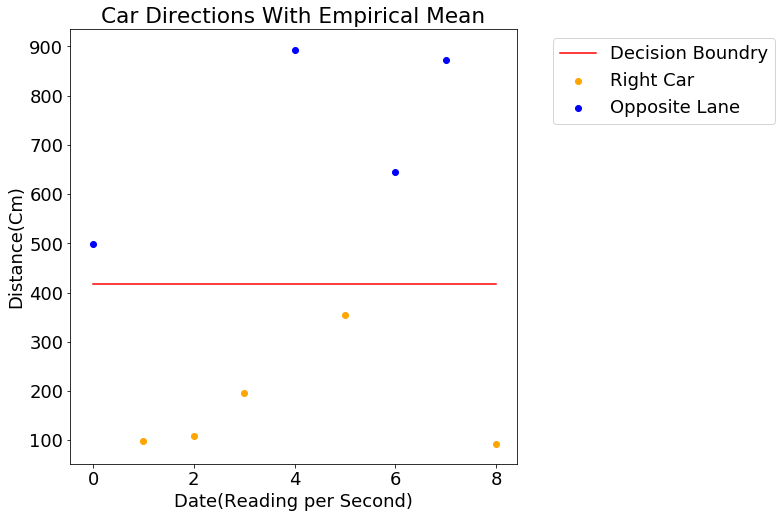

In [104]:
plt.scatter(right_car.column("Standardize Time"), right_car.column("Distance(CM)"), 
            label='Right Car', color='orange')
plt.scatter(opposite_car.column("Standardize Time"), opposite_car.column("Distance(CM)"), 
            label='Opposite Lane', color='blue')
plt.plot(standardize_date, empirical_dist_mean_arr,
            label='Decision Boundry', color='red')

plt.title("Car Directions With Empirical Mean")
plt.xlabel("Date(Reading per Second)")
plt.ylabel("Distance(Cm)")
plt.legend(bbox_to_anchor = (1.6, 1), loc='upper right')
print("Error Distance", empirical_mean_distance / cond_mean_distance)

# Empirical Velocity

Just a quick observation: when the distance readings are plotted against the Deltatime, we see a linear relationship. This should make sense since distance over time is velocity! It is important to note that velocity in our observations is in centimeters not the SI standard of meters.

Since the relationship between Deltatime and Distance appears to be linear, this relationship can be analyzed with linear regression. Thus, the functions defined below will be used to describe this relationship.

In [105]:
def correlation(x_su, y_su):
    """This function takes in two standardized vectors and 
        returns the correlation coefficient bwtween them"""
    return np.mean(x_su * y_su)

def regression_slope(correlation, x, y):
    """This function takes in the Correlation Coefficient between the parameter/observed vectors,
        parameter vector, and observed vector and returns the slope of the linear regression function"""
    return correlation * (np.std(y) / np.std(x))

def regression_intercept(x, y, slope):
    """This function takes in a parameter vector, observed vector, and linear regression slope and
        returns the corresponding intercept"""
    return np.mean(y) - np.mean(x) * slope

def fitted_values(x, slope, intercept):
    """This function takes in a parameter vector, slope, and intercept of the linear regression function and
        returns an array that contains the prediction values corresponding to the parameter vector."""
    fitted_vals = np.array(list(map(lambda dep_var: slope * dep_var + intercept, x)))
    return fitted_vals

def residuals(y, y_hat):
    """This function takes in an observed vector and the prediction vector and returns
        a vector containing the residuals"""
    return y - y_hat

def rms(y, y_hat): # change to rmse
    """Computes the root mean squared differences between y and y_hat"""
    return np.sqrt(np.mean(residuals(y, y_hat)**2))

def standardize_values(vector):
    # z = (val - mean(val)) / SD(val)
    """This function takes in a array and returns the standardized values 
        for each element in the array."""
    return (vector - np.mean(vector)) / np.std(vector)

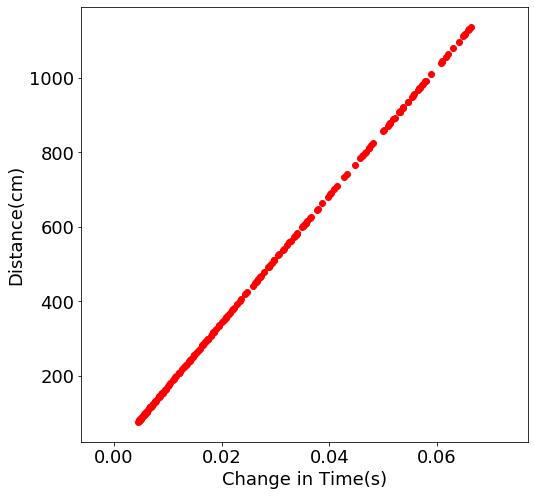

In [106]:
plt.scatter(filter_deltatime, filter_distance_cm, color='red');
plt.xlabel('Change in Time(s)')
plt.ylabel('Distance(cm)');

In [107]:
# linear regression eq 
su_deltatime = standardize_values(filter_deltatime)
su_distance = standardize_values(filter_distance_cm)

r = correlation(su_deltatime, su_distance)
slope = regression_slope(r, filter_deltatime, filter_distance_cm)
intercept = regression_intercept(filter_deltatime, filter_distance_cm, slope)
prediction_vals = fitted_values(filter_deltatime, slope, intercept)
residual_vals = residuals(filter_distance_cm, prediction_vals)
velocity_rms = rms(filter_distance_cm, prediction_vals)

display(Markdown("Regression Velocity Equation: $$ V_R(t) = {0}t + {1} $$".format(
                np.round(slope, 3), np.round(intercept, 5))))

display(Markdown("RMS Error for velocity regression equation: {0}".format(np.round(velocity_rms, 4))))

Regression Velocity Equation: $$ V_R(t) = 17150.0t + 2e-05 $$

RMS Error for velocity regression equation: 0.0003

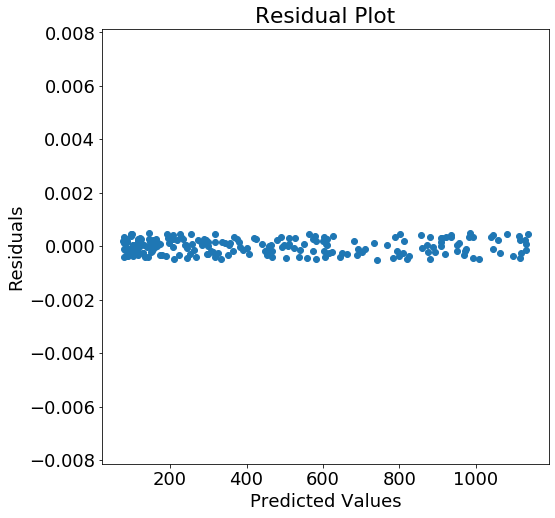

In [108]:
plt.scatter(prediction_vals, residual_vals);
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title("Residual Plot");

Thus, the corresponding regression function can be observed as follows:

Regression Velocity Equation: $$ V_R(t) = 17150.0t + 2e-05 $$

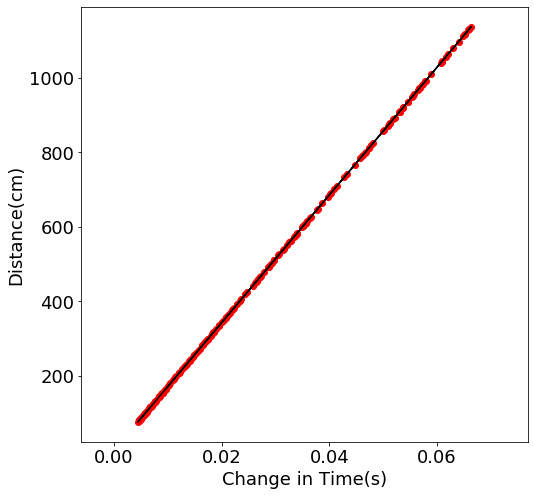

In [109]:
plt.scatter(filter_deltatime, filter_distance_cm, color='red');
plt.xlabel('Change in Time(s)')
plt.ylabel('Distance(cm)');
plt.plot(filter_deltatime, prediction_vals, color = 'black');
display(Markdown("Regression Velocity Equation: $$ V_R(t) = {0}t + {1} $$".format(
                np.round(slope, 3), np.round(intercept, 5))))

Distance: 771.75002cm, or 25.0ft. 


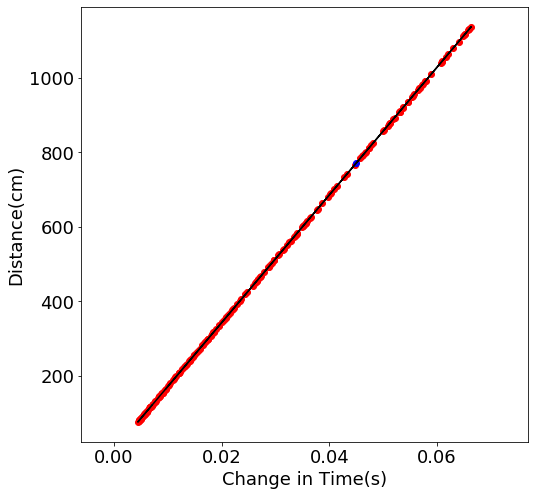

In [110]:
plt.scatter(filter_deltatime, filter_distance_cm, color='red');
plt.xlabel('Change in Time(s)')
plt.ylabel('Distance(cm)');
plt.plot(filter_deltatime, prediction_vals, color = 'black');


reg_velocity = lambda t: np.round(slope, 3) * t +  np.round(intercept, 5)
print("Distance: {0}cm, or {1}ft. ".format(reg_velocity(0.045), np.round(reg_velocity(0.045) * 3.28 / 100), 3))
plt.scatter(0.045, reg_velocity(0.045), color='blue'); # the predicited distance[cm] when a car passed of DELTATIME 2[s]

For the second filtered table

In [111]:
su_cdt = standardize_values(cond_delta_time)
su_dist = standardize_values(cond_distance)
cond_r = correlation(su_cdt, su_dist)
cond_slope = regression_slope(cond_r, cond_delta_time, cond_distance)
cond_intercept = regression_intercept(cond_delta_time, cond_distance, cond_slope)
cond_fitted_vals = fitted_values(cond_delta_time, cond_slope, cond_intercept)
cond_residuals = residuals(cond_distance, cond_fitted_vals)
cond_rms = rms(cond_distance, cond_fitted_vals)

display(Markdown("Regression Velocity Equation: $$ V_R(t) = {0}t + {1} $$".format(
                np.round(cond_slope, 3), np.round(cond_intercept, 5))))

Regression Velocity Equation: $$ V_R(t) = 17149.993t + 0.00019 $$

In [112]:
cond_regression_velocity = lambda t: cond_slope * t + cond_intercept 

Regression Velocity Equation: $$ V_R(t) = 17149.993t + 0.00019 $$

Distance 771.7498789067349 Cm


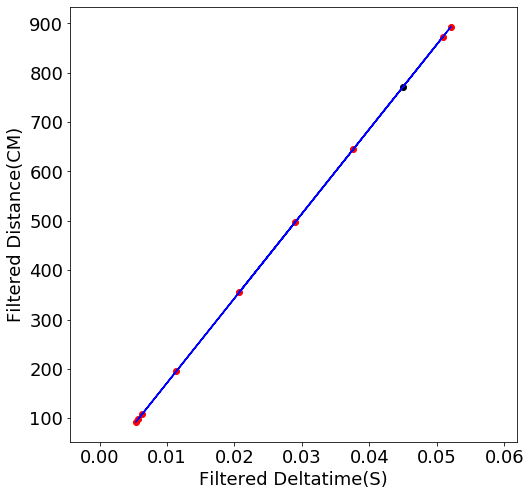

In [113]:
plt.scatter(cond_delta_time, cond_distance, color='red')
plt.plot(cond_delta_time, cond_fitted_vals, color='blue')
plt.xlabel('Filtered Deltatime(S)')
plt.ylabel('Filtered Distance(CM)');

plt.scatter(0.045, cond_regression_velocity(0.045), color='black');
display(Markdown("Regression Velocity Equation: $$ V_R(t) = {0}t + {1} $$".format(
                np.round(cond_slope, 3), np.round(cond_intercept, 5))))
print('Distance', cond_regression_velocity(0.045), 'Cm')

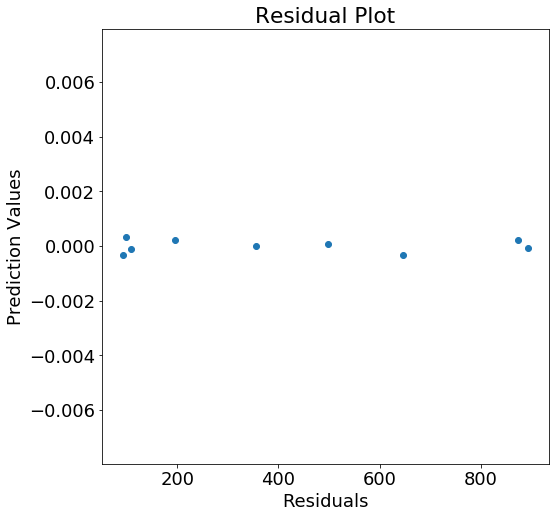

In [114]:
plt.scatter(cond_fitted_vals, cond_residuals)
plt.title('Residual Plot')
plt.xlabel('Residuals')
plt.ylabel('Prediction Values');

# Conclusion

After removing the noise, and imposing the two assumptions, 9 cars had passed the street within a 2-hour interval. Furthermore, when classifying the direction of cars based on the average distance measurements, 4 cars were in the opposite lane which implies that 4 cars passed into the street, and 5 cars were in the same lane as the location of the sensor which implies that 5 cars left the street.

In regards to the regression velocity equations, each regression function has a Correlation Coefficient Value of 0.9 for the first data filtration and second data filtration process. The regression functions 

$$ 𝑉_{𝑅1}(𝑡)=17150.0𝑡+2𝑒−05 $$ 
$$𝑉_{𝑅2}(𝑡)=17149.993𝑡+0.00019,$$ 

where $𝑉_{𝑅1}$ was subjected to the first round data filtration process and $𝑉_{𝑅2}$ was subjected to first and second data filtration. Upon inspecting the asymptotic behavior as a rato $\dfrac{𝑉_{𝑅1}}{𝑉_{𝑅2}}$, the regression functions displayed an accuracy up to $10^6$.

From this process, a few possibilities are present. Due to finding an analytical expression of velocity that expresses this system, we can take this information a step further and find the displacement function that describes this system. 

Also, since binary classification is present within the data, a machine learning classification algorithm(such as Kth Nearest Neighbors) can be applied to predict the direction of a car is traveling with respect to the location of the sensor. Furthermore, although to a lesser extent, a numerical machine learning algorithm to predict the distance of an object given the features presented in the filtered data.